In [ ]:
import tensorflow_datasets.public_api as tfds

def obtain_data():
  dataset, info = tfds.load("davis", with_info=True)
  train_dataset = dataset['train']
  val_dataset = dataset['validation']
  split_info_list = list(info.splits.items())
  train_dataset_size = split_info_list[0][1].num_examples
  val_dataset_size = split_info_list[1][1].num_examples
  train_dataset_no_metadata = [sample['video'] for sample in train_dataset.take(1)] # train_dataset (y train_dataset.take(X)) es un objeto Dataset, x es un dict, y x["video"] también es un dict
  val_dataset_no_metadata = [sample['video'] for sample in val_dataset.take(1)]
  train_frames = [item['frames'] for item in train_dataset_no_metadata] # train_dataset_pure es una lista, "item" es un dict, y item["frames"] es un tensor
  train_segmentations = [item['segmentations'] for item in train_dataset_no_metadata]
  val_frames = [item['frames'] for item in val_dataset_no_metadata]
  val_segmentations = [item['segmentations'] for item in val_dataset_no_metadata]
  return train_frames, train_segmentations, val_frames, val_segmentations

train_frames, train_segmentations, val_frames, val_segmentations = obtain_data()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def overlay_mask_on_frame(image, mask):
  # Normalizar la imagen al rango [0, 1]
  image = tf.cast(image, tf.float16) / 255.0
  # Normalizar la máscara al rango [0, 1]
  mask_min = tf.reduce_min(mask)
  mask_max = tf.reduce_max(mask)
  mask = (mask - mask_min) / (mask_max - mask_min)

  cmap = plt.get_cmap('jet')
  mask_rgb = tf.convert_to_tensor(cmap(mask)[:, :, 0, :3], dtype=tf.float16)

  # Superponer la máscara sobre la imagen
  overlay = tf.clip_by_value(image + mask_rgb, 0.0, 1.0)

  # Convertir la imagen al rango [0, 255]
  return tf.cast(overlay * 255.0, tf.uint8) # type: ignore

def create_video_from_frames_and_masks(frames, masks, output_path, fps=30):
  height, width, _ = frames[0].shape
  # codec para mp4
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # type: ignore
  out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

  for i in range(len(frames)):
    frame = frames[i]
    mask = masks[i]
    overlay = overlay_mask_on_frame(frame, mask)
    out.write(overlay.numpy())

  out.release()
  print(f'Vídeo guardado en {output_path}')

video_frames = train_frames[0]  # Tensor de fotogramas del primer vídeo
video_masks = train_segmentations[0]  # Tensor de máscaras del primer vídeo
create_video_from_frames_and_masks(video_frames, video_masks, 'output_video.mp4')

Vídeo guardado en output_video.mp4


In [ ]:
# ahora tengo listas de tensores (cada tensor es un vídeo entero). no puedo meterlo en un tensor porque cada vídeo tiene duración y dimensiones diferente
# una red neuronal recibe tensores. entonces o entreno a la red vídeo por vídeo, o hago lotes metiendo en un tensor a todos aquellos vídeos de igual duración y dimensiones
# voy a hacer lo segundo (cada lote tendrá una longitud distinta):
def batch_tensors(tensor_list):
  grouped_tensors = {}

  for tensor in tensor_list:
    shape = tensor.shape
    if shape not in grouped_tensors:
      grouped_tensors[shape] = []
    grouped_tensors[shape].append(tensor)

  batched_groups = {}
  for shape, tensors in grouped_tensors.items():
    # Convertir la lista de tensores en un tensor
    batched_group = tf.stack(tensors)
    batched_groups[shape] = batched_group
  # batched_groups es un dict donde en una pareja, la clave es el número de frames, y el valor es el tensor de todos los vídeos de esa duración
  return batched_groups

In [ ]:
# recibe el DICCIONARIO donde están las máscaras, y halla el  número de clases únicas (valores únicos)
def find_number_of_classes(mask_dict):
  unique_classes = tf.constant([], dtype=tf.uint8)
  for num_frames, mask_tensor in mask_dict.items():
    # Aplanar el tensor de máscaras y encontrar los valores únicos
    mask_unique_values = tf.unique(tf.reshape(mask_tensor, [-1]))[0]
    # Concatenar los valores únicos encontrados con los anteriores
    unique_classes = tf.concat([unique_classes, mask_unique_values], axis=0)
  # Finalmente, encontrar los valores únicos de todos los concatenados
  unique_classes = tf.unique(unique_classes)[0]
  return unique_classes.shape[0]

# hay 10 clases (valores distintos en las máscaras)

In [ ]:
pip install keras_cv

In [ ]:
from tensorflow.keras import layers, Model # type: ignore
from keras.layers import Conv3D
# este modelo tiene un bloque CNN y un bloque RNN
class MaskRCNN(Model):
  def __init__(self, num_classes):
    super(MaskRCNN, self).__init__()

    # TODO: encontrar un backbone para vídeo y que sea CNN
    self.backbone = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')

    # Capa recurrente (para las relaciones temporales)
    self.rnn = layers.ConvLSTM2D(256, kernel_size=3, padding="same", return_sequences=True)

    # Capa final para la predicción de las máscaras
    self.out_mask = layers.Conv2D(num_classes, kernel_size=1, activation="softmax")

  def call(self, inputs):
    # Extracción de características con CNN
    x = self.backbone(inputs)
    # Procesamiento temporal con la capa recurrente
    x = self.rnn(x)
    # Generar la predicción de la máscara
    output = self.out_mask(x)
    return output

In [ ]:
def iou_per_class(mask_true, mask_pred, number_of_classes, smooth):
  intersection = tf.reduce_sum(mask_true * mask_pred)
  union = tf.reduce_sum(mask_true) + tf.reduce_sum(mask_pred) - intersection
  iou = intersection + smooth / union + smooth
  return iou

def iou_loss_multiclass(mask_true, mask_pred, number_of_classes, smooth=1e-6):
  # tanto en mask_true como en mask_pred puede haber varias máscaras a la vez
  # por lo tanto hago cada iou por separado y luego hago la media ponderada por tamaño de máscara

  mask_true_one_hot = tf.one_hot(mask_true, depth=number_of_classes)
  mask_pred_one_hot = tf.one_hot(mask_pred, depth=number_of_classes)
  ious = [iou_per_class(mask_true, mask_pred, number_of_classes, smooth) for c in range(number_of_classes)]
  # TODO: hacer media PONDERADA
  return tf.reduce_mean(ious)

In [ ]:
import tensorflow as tf

def get_video_and_mask(video_dict, mask_dict, shape):
  video_tensor = video_dict[shape]
  mask_tensor = mask_dict[shape]
  return video_tensor, mask_tensor

def batch_video_frames(video_tensor, mask_tensor, batch_size):
  num_examples = tf.shape(video_tensor)[0]
  for i in range(num_examples):
    video_frame = video_tensor[i]
    mask_frame = mask_tensor[i]
    num_frames = tf.shape(video_frame)[0]
    # Dividir el vídeo en batches de frames
    for start in range(0, num_frames, batch_size):
      end = min(start + batch_size, num_frames)
      yield video_frame[start:end], mask_frame[start:end]

def video_mask_generator(video_dict, mask_dict, batch_size):
  for shape in video_dict:
    video_tensor, mask_tensor = get_video_and_mask(video_dict, mask_dict, shape)
    yield from batch_video_frames(video_tensor, mask_tensor, batch_size)

def create_dataset_from_dicts(video_dict, mask_dict, batch_size):
  dataset = tf.data.Dataset.from_generator(
      lambda: video_mask_generator(video_dict, mask_dict, batch_size),
      output_signature=(
        tf.TensorSpec(shape=(None, *next(iter(video_dict.values())).shape[1:]), dtype=tf.float16), # type: ignore
        tf.TensorSpec(shape=(None, *next(iter(mask_dict.values())).shape[1:]), dtype=tf.float16) # type: ignore
      )
  )
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
batch_size = 16

train_video_dict = batch_tensors(train_frames)
train_mask_dict = batch_tensors(train_segmentations)
train_dataset = create_dataset_from_dicts(train_video_dict, train_mask_dict, batch_size)

val_video_dict = batch_tensors(val_frames)
val_mask_dict = batch_tensors(val_segmentations)
val_dataset = create_dataset_from_dicts(val_video_dict, val_mask_dict, batch_size)

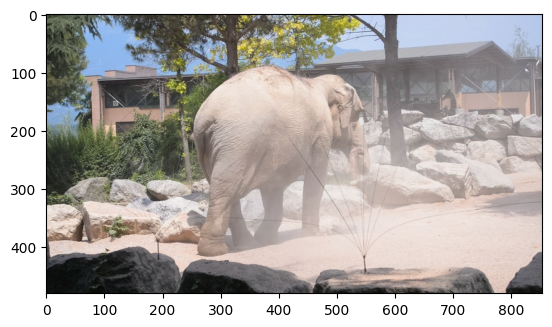

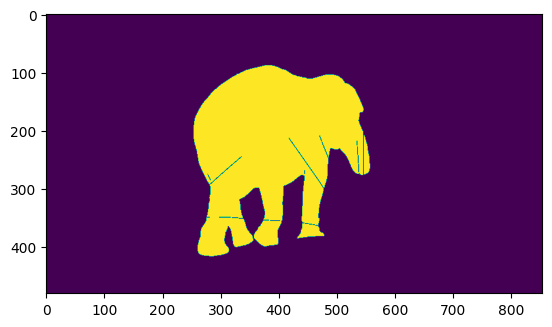

In [ ]:
first_shape_video = next(iter(train_video_dict.keys()))
first_shape_mask = next(iter(train_mask_dict.keys()))
first_frame = train_video_dict[first_shape_video][0][0] # de dcha a izda, el primer frame del primer ejemplo
first_mask = train_mask_dict[first_shape_mask][0][0]

plt.imshow(first_frame)
plt.show()
plt.imshow(first_mask)
plt.show()

In [ ]:
# num_classes = find_number_of_classes(mask_dict)
num_classes = 10

model = MaskRCNN(num_classes)
model.compile(optimizer='adam',
              loss=lambda mask_true, mask_pred : iou_loss_multiclass(mask_true, mask_pred, num_classes))

In [ ]:
history = model.fit(train_dataset, epochs=1, validation_data=val_dataset, verbose=2)

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "<ipython-input-11-1b0dc22a74d0>", line 6, in None  *
        lambda mask_true, mask_pred : iou_loss_multiclass(mask_true, mask_pred, num_classes)
    File "<ipython-input-22-98f3a19f6c10>", line 10, in iou_loss_multiclass  *
        mask_true_one_hot = tf.one_hot(mask_true, depth=number_of_classes, dtype=tf.uint8)

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int8, int32, int64
